# <u>Data Augmentation for Genetic Data</u>

## 1. Pre-processing

### 1.1 Packages

In [1]:
import pandas as pd

import numpy as np

from matplotlib import pyplot as plt

import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.decomposition import PCA

from scipy.stats import chi2_contingency, spearmanr

from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings('ignore')

### 1.2 Import Data

In [2]:
df = pd.read_csv(r"data\vcf_with_labels.csv")
samples = df['samples']
df = df.drop(columns = ['samples', 'score'])
columns = df.columns[1:]

### 1.3 Split train and test sets

In [3]:
y = df.label.values
X = df.drop(columns = 'label').values
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.3,
                                                    random_state = 999,
                                                    stratify = y)

print("Orginal dataset shape:", df.shape)
print("Features training dataset shape after split:", X_train.shape)
print("Features test dataset shape after split:", X_test.shape)
print("Target training dataset shape after split:", y_train.shape)
print("Target test dataset shape after split:", y_test.shape)

Orginal dataset shape: (1033, 1989)
Features training dataset shape after split: (723, 1988)
Features test dataset shape after split: (310, 1988)
Target training dataset shape after split: (723,)
Target test dataset shape after split: (310,)


## 2. EDA

### 2.1 Check for missing values
There are no missing values in the dataset.

In [4]:
df.isnull().sum()

label                  0
chr22:16050408:T:C     0
chr22:16050612:C:G     0
chr22:16050678:C:T     0
chr22:16050984:C:G     0
                      ..
chr22:17796926:T:TA    0
chr22:17796951:A:G     0
chr22:17796971:C:A     0
chr22:17797010:G:A     0
chr22:17797041:T:C     0
Length: 1989, dtype: int64

In [5]:
df.isnull().sum().sum()

0

### 2.2 Label Distributions
The labels in the dataset can take on a value of 0 or 1. A value of 0 means there is no disease present in the person represented by that row, while a value of 1 means the disease is present. The dataset is imbalanced, with a ratio of approximately 3:2 observations of no disease to disease. This means that a scoring metric needs to be chosen that can account for imbalance in the dataset. It also provides the opportunity to experiment with oversampling techniques.

In [6]:
label_counts = df['label'].value_counts()

Text(0.5, 0, 'Disease Presence (0: No, 1: Yes)')

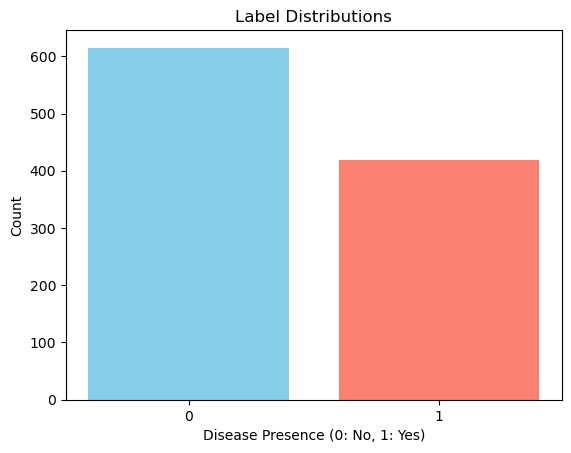

In [7]:
fig, ax = plt.subplots()

ax.bar(label_counts.index, label_counts, tick_label = label_counts.index,color=['skyblue', 'salmon'])
ax.set_title('Label Distributions')
ax.set_ylabel('Count')
ax.set_xlabel('Disease Presence (0: No, 1: Yes)')

### 2.3 Human Genetic Data Columns
The features of the dataset are genes, and their values can take on 0, 1 or 2. A value of 0 means there is no mutation present, a value of 1 means 'half' a mutation is present, and a value of 2 represents a 'full' mutation.

In [8]:
df.drop(columns='label').head()

,chr22:16050408:T:C,chr22:16050612:C:G,chr22:16050678:C:T,chr22:16050984:C:G,chr22:16051107:C:A,chr22:16051249:T:C,chr22:16051347:G:C,chr22:16051453:A:C,chr22:16051477:C:A,chr22:16051480:T:C,...,chr22:17796639:C:T,chr22:17796685:T:A,chr22:17796833:T:C,chr22:17796921:T:TTAAC,chr22:17796925:C:CTAAT,chr22:17796926:T:TA,chr22:17796951:A:G,chr22:17796971:C:A,chr22:17797010:G:A,chr22:17797041:T:C
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,1,0,0
1,1,1,1,0,1,1,1,1,0,1,...,0,1,0,1,1,1,0,0,0,0
2,1,1,1,0,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df['chr22:17726469:T:G'].value_counts()

2    666
1    311
0     56
Name: chr22:17726469:T:G, dtype: int64

#### 2.3.1 Visualising Column Means
The means for each column of gene mutations were visualised. It can be seen that the vast majority of means are very small, close to zero.  90% of the means are less than 0.50, and only around 5% have a mean mutation of more than 1. Only a small portion of columns contain a significant amount of mutation.

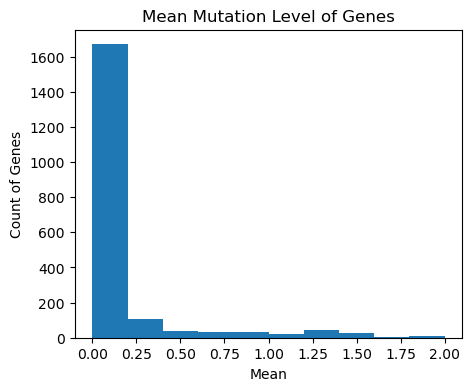

The percentage of columns with a mean mutation of less than 0.50 is 89.99%
The percentage of columns with a mean mutation greater than 1 is 5.43%


In [10]:
means = df.drop(columns = 'label').describe().iloc[1]

fig, ax = plt.subplots(figsize=(5, 4))

ax.hist(means)
ax.set_title('Mean Mutation Level of Genes')
ax.set_xlabel('Mean')
ax.set_ylabel('Count of Genes')

plt.show()

small_means_pct = len(means[means <= .5])/len(means)*100
large_means_pct = len(means[means > 1])/len(means)*100
print(f"The percentage of columns with a mean mutation of less than 0.50 is {small_means_pct:.2f}%")
print(f"The percentage of columns with a mean mutation greater than 1 is {large_means_pct:.2f}%")

Looking at the value counts, it can be seen that there are a number of recurring values. The value 0.000968 occurs 449 times and is equal to 1/1,033, with 1,033 being the number of rows in the dataset. This means that it is most common for any column to have only one occurrence of a mutation in the dataset. The next most common value is 0.001936 = 2/1,033, meaning only two occurrences of a half mutation or one full mutation, and the next is 0.002904 = 3/1,033 and so on. Mutations in the genes are very rare for most of the genes.

In [11]:
means.value_counts()

0.000968    449
0.001936    151
0.002904     98
0.003872     72
0.004840     57
           ... 
0.900290      1
0.079380      1
0.547919      1
1.286544      1
0.798645      1
Name: mean, Length: 430, dtype: int64

### 2.4 Correlation between genes and labels 

#### 2.4.1 Chi-squared test for independence
154 features have a statistically significant association with the target variable. The association indicates that the distributions of these feature values are not independent of the target variable values.

In [12]:
ordinal_columns = df.drop(columns='label').columns

chisq_results = []

for col in ordinal_columns:
    # Create a contingency table
    contingency_table = pd.crosstab(df[col], df['label'])

    # Perform the chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    chisq_results.append({
        "Column": col,
        "Chi-Square Statistic": chi2,
        "P-value": p,
        "Degrees of Freedom": dof,
        "Expected Frequencies Table": expected
    })

In [13]:
count = 0
for result in chisq_results:
    if result['P-value'] < 0.05:
        count += 1
        
print(count)

154


#### 2.4.2 Spearman Rank Coefficient 
Out of the 1988 features, 238 features have a p-value less than 0.05 when correlated with the target variable. As the value of these features increases or decreases, the target variable tends to consistently increase or decrease.

In [14]:
spearmanr_results = []

for col in ordinal_columns:
    # Calculate Spearman's rank correlation
    rho, p_value = spearmanr(df[col], df['label'])
    
    spearmanr_results.append({
        "Column": col,
        "Correlation": rho,
        "P-value": p_value
    })

In [15]:
count = 0
for result in spearmanr_results:
    if result['P-value'] < 0.05:
        count += 1
        
print(count)

238


#### 2.4.3 Visualising the Means of Significant Columns
Visualising the means of the columns with significant correlations to the disease, it can be seen that the columns with a large amount of mutatation are more represented than before. More mutation does appear to suggest a higher likelihood of disease.

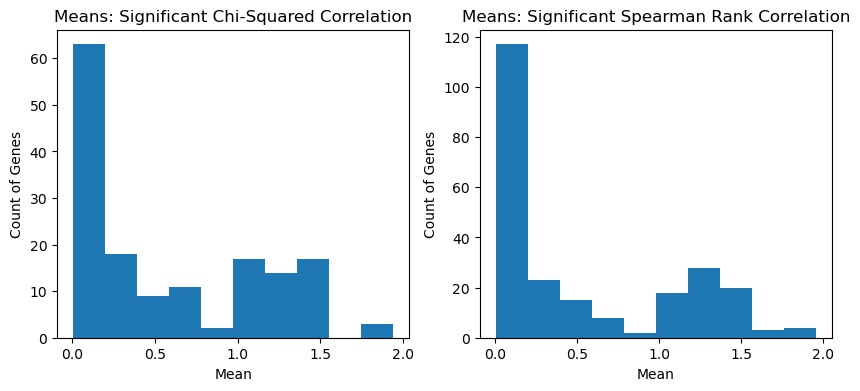

In [16]:
# Get significant column names
chi_significant_cols = []
for result in chisq_results:
    if result['P-value'] < 0.05:
        chi_significant_cols.append(result['Column'])
spear_significant_cols = []
for result in spearmanr_results:
    if result['P-value'] < 0.05:
        spear_significant_cols.append(result['Column'])
        
# Summarise means
chi_means = df[chi_significant_cols].describe().iloc[1]      
spear_means = df[spear_significant_cols].describe().iloc[1]

# Plot means
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].hist(chi_means)
axs[0].set_title('Means: Significant Chi-Squared Correlation')
axs[0].set_xlabel('Mean')
axs[0].set_ylabel('Count of Genes')

axs[1].hist(spear_means)
axs[1].set_title('Means: Significant Spearman Rank Correlation')
axs[1].set_xlabel('Mean')
axs[1].set_ylabel('Count of Genes')

plt.show()

### 2.5 Principal Component Analysis (PCA)
A PCA was performed on the training data. From the resulting variance plot, it can be seen that the first 200 components explain about 95% of the variance. The score plot of the first two components does not show clusters for the disease label, unfortunately.

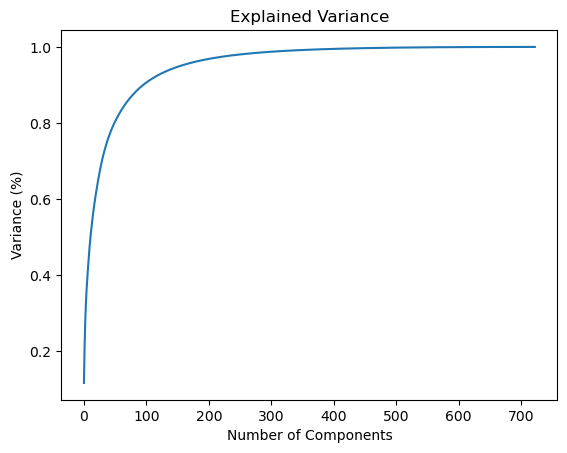

In [17]:
pca = PCA().fit(X_train)

# Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') 
plt.title('Explained Variance')
plt.show()

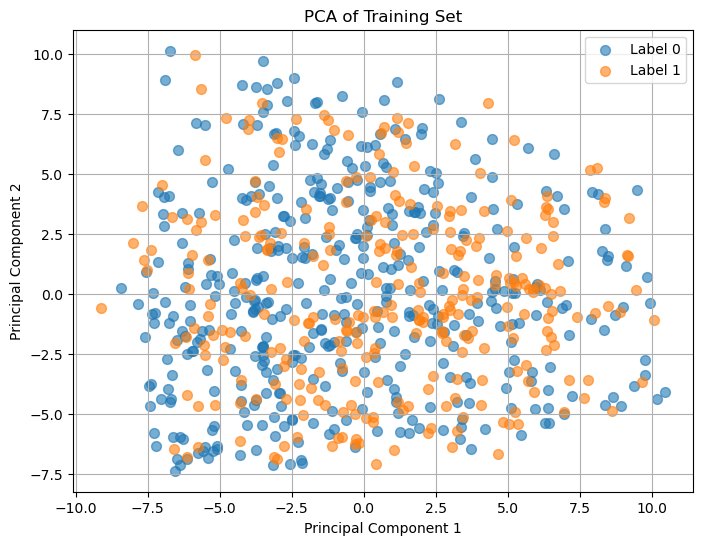

In [18]:
pca = PCA(n_components=200)
X_pca = pca.fit_transform(X_train)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y_train == 0][:, 0], X_pca[y_train == 0][:, 1], s=50, label='Label 0', alpha=0.6)
plt.scatter(X_pca[y_train == 1][:, 0], X_pca[y_train == 1][:, 1], s=50, label='Label 1', alpha=0.6)
plt.title('PCA of Training Set')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

## 3. Run Models 

### 3.1 Search for Good Experimental Hyperparameters to Serve as Baseline

In [19]:
# Set parameters
rf_classifier = RandomForestClassifier(random_state = 999)

cv_method = RepeatedStratifiedKFold(n_splits=5,
                                    n_repeats=3,
                                    random_state=999)

scoring_metric = 'f1' # For class imbalance

params_RF = {'criterion': ['gini','entropy'],
             'n_estimators':[100, 115, 130],
             'max_depth': [40, 50, 60]}

#### 3.1.1 Baseline Without PCA

In [20]:
# Perform GridSearch
gs_RF = GridSearchCV(estimator=rf_classifier,
                     param_grid=params_RF,
                     cv=cv_method,
                     verbose=1,
                     scoring=scoring_metric)

gs_RF.fit(X_train, y_train)

Fitting 15 folds for each of 18 candidates, totalling 270 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=999),
             estimator=RandomForestClassifier(random_state=999),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [40, 50, 60],
                         'n_estimators': [100, 115, 130]},
             scoring='f1', verbose=1)

In [21]:
print('The best parameters for Random Forest Classifier without PCA are: ', gs_RF.best_params_)
print("The best score using the F1 metric is:", round(gs_RF.best_score_,3))

The best parameters for Random Forest Classifier without PCA are:  {'criterion': 'entropy', 'max_depth': 50, 'n_estimators': 115}
The best score using the F1 metric is: 0.407


#### 3.1.2 Baseline With PCA

In [22]:
# Perform GridSearch
gs_RF = GridSearchCV(estimator=rf_classifier,
                     param_grid=params_RF,
                     cv=cv_method,
                     verbose=1,
                     scoring=scoring_metric)

gs_RF.fit(X_pca, y_train)

Fitting 15 folds for each of 18 candidates, totalling 270 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=999),
             estimator=RandomForestClassifier(random_state=999),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [40, 50, 60],
                         'n_estimators': [100, 115, 130]},
             scoring='f1', verbose=1)

In [23]:
print('The best parameters for Random Forest Classifier with PCA are: ', gs_RF.best_params_)
print("The best score using the F1 metric is:", round(gs_RF.best_score_,3))

The best parameters for Random Forest Classifier with PCA are:  {'criterion': 'entropy', 'max_depth': 40, 'n_estimators': 100}
The best score using the F1 metric is: 0.21


The F1 results above suggest that some information that's useful for classification is lost during the PCA transformation. Therefore, we will proceed without PCA.

In [24]:
# Set baseline parameters
base_params = {'criterion': 'entropy',
             'n_estimators': 115,
             'max_depth': 50}

### 3.2 Model Building

In [25]:
def train_runs(X_train, y_train, X_test, y_test, base_params, seeds):
    """
    Builds RF Classifiers and returns relevant metrics
    """
    results = {}
    importances = [0] * len(X_train[0])
    
    for seed in seeds:

        rf_classifier = RandomForestClassifier( random_state=seed, **base_params)

        rf_classifier.fit(X_train, y_train)

        y_pred = rf_classifier.predict(X_test)
        
        results[str(seed)] = classification_report(y_test, y_pred, output_dict = True)
        
        y_scores = rf_classifier.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_scores)
        auc_score = roc_auc_score(y_test, y_scores)
        results[str(seed)]['fpr'] = fpr
        results[str(seed)]['tpr'] = tpr
        results[str(seed)]['thresholds'] = thresholds
        results[str(seed)]['auc'] = auc_score
        importances += rf_classifier.feature_importances_
    
    importances = [x / len(seeds) for x in importances]
    
    return results, importances

In [26]:
# Do 30 runs of each technique using as many seeds
seeds = np.arange(0, 30)

### 3.3 Data Augmentation and Oversampling Techniques

#### 3.3.1 Mixup

Mixup is a data augmentation technique that generates a weighted combination of random pairs from the training data.

In [27]:
def ratio_mixup(x, y, alpha, beta_dis = False):
    """
    Returns mixed inputs and mixed labels using cross-label augmentation.
    """
    if beta_dis == True:
        lam = np.random.beta(alpha, alpha)
        lams = np.array([lam])
        for i in range(len(y) - 1):
            lam = np.random.beta(alpha, alpha)
            lams = np.vstack((lams, lam))
            
        batch_size = x.shape[0]
        index = np.random.permutation(batch_size)
        mixed_x = lams * x + (1 - lams) * x[index, :]
        mixed_y = lams * y + (1 - lams) * y[index]
        
    else:
        batch_size = x.shape[0]
        index = np.random.permutation(batch_size)
        mixed_x = alpha * x + (1 - alpha) * x[index, :]
        mixed_y = alpha * y + (1 - alpha) * y[index]
    
    mixed_y = (mixed_y >= 0.5).astype(int)
    
    return mixed_x, mixed_y

ratios = [0.1, 0.3, 0.4999, 0.7, 0.9]
mixup_data = {}

for ratio in ratios:
    X_mix, y_mix = ratio_mixup(X_train, y_train, ratio)
    mixup_data[f'mixup_{ratio}'] = {'X':X_mix, 'y':y_mix}
    
X_mix, y_mix = ratio_mixup(X_train, y_train, 0.2, beta_dis = True)
mixup_beta = {'X':X_mix, 'y':y_mix}

#### 3.3.2 Noise Injection

Uniform noise: Adding random values from a constant range to data points for augmentation.  
Gaussian noise: Introducing variations to data points based on a normal distribution for augmentation.

In [28]:
np.random.seed(999)

def add_gaussian_noise(X, sigma=0.1):
    noise = np.random.normal(0, sigma, X.shape)
    return X + noise

def add_uniform_noise(X, intensity=0.1):
    noise = np.random.uniform(-intensity, intensity, X.shape)
    return X + noise

noise_levels = [0.01, 0.03, 0.05]
noise_data = {}

for level in noise_levels:
    X_gaussian = add_gaussian_noise(X_train, sigma=level)
    X_uniform = add_uniform_noise(X_train, intensity=level)
    noise_data[f'gaussian_{level}'] = X_gaussian
    noise_data[f'uniform_{level}'] = X_uniform

#### 3.3.3 Synthetic Minority Oversampling Technique (SMOTE)

SMOTE: A data augmentation technique that generates synthetic samples in the feature space to balance an imbalanced dataset.

In [29]:
smote = SMOTE(random_state=999)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

#### 3.3.4 Adaptive Synthetic Sampling (ADASYN)

ADASYN: A data augmentation technique that adaptively generates synthetic samples based on the distribution of minority class instances, emphasizing regions where classification is difficult.

In [30]:
adasyn = ADASYN(random_state=999)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

#### 3.3.5 Random Undersampling and Random Oversampling

Random Undersampling: Reducing the number of samples from over-represented classes to balance the dataset.  
Random Oversampling: Duplicating or generating additional samples for under-represented classes to balance the dataset.

In [31]:
rus = RandomUnderSampler(random_state=999)
X_under, y_under = rus.fit_resample(X_train, y_train)

ros = RandomOverSampler(random_state=999)
X_over, y_over = ros.fit_resample(X_train, y_train)

### 3.4 PCA plots

In [32]:
def plot_pca(X_pca, y, title, ax):
    ax.scatter(X_pca[y == 0][:, 0], X_pca[y == 0][:, 1], s=50, label='Label 0', alpha=0.6)
    ax.scatter(X_pca[y == 1][:, 0], X_pca[y == 1][:, 1], s=50, label='Label 1', alpha=0.6)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('Principal Component 1', fontsize=8)
    ax.set_ylabel('Principal Component 2', fontsize=8)
    ax.legend(fontsize=7)
    ax.grid(True)

#### 3.4.1 Mixup PCA

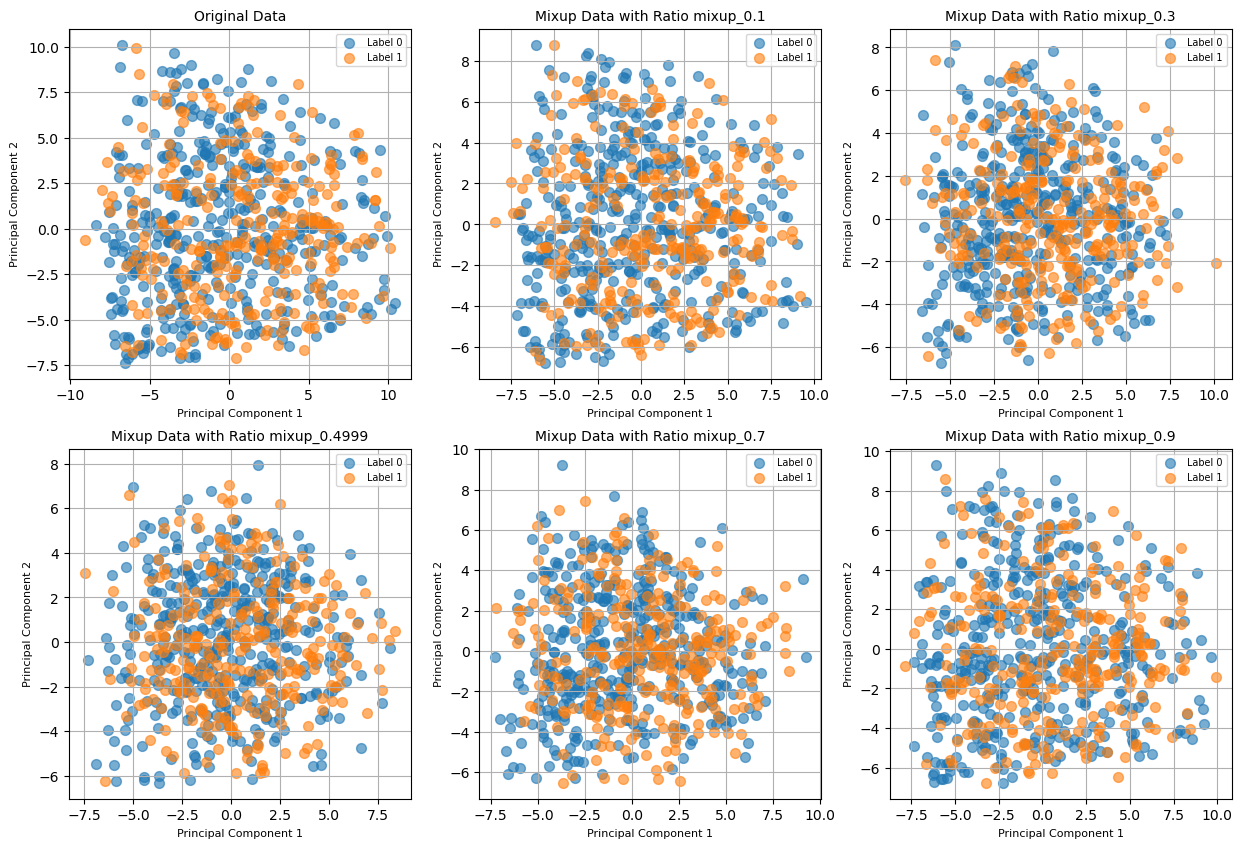

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

positions = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]
plot_pca(X_pca, y_train, 'Original Data', axes[positions[0]])
i = 1
for ratio, data in mixup_data.items():
    X_mix = data['X']
    y_mix = data['y']
    X_mix_pca = pca.transform(X_mix)
    plot_pca(X_mix_pca, y_mix, f'Mixup Data with Ratio {ratio}', axes[positions[i]])
    i += 1

#### 3.4.2 Noise Injection PCA

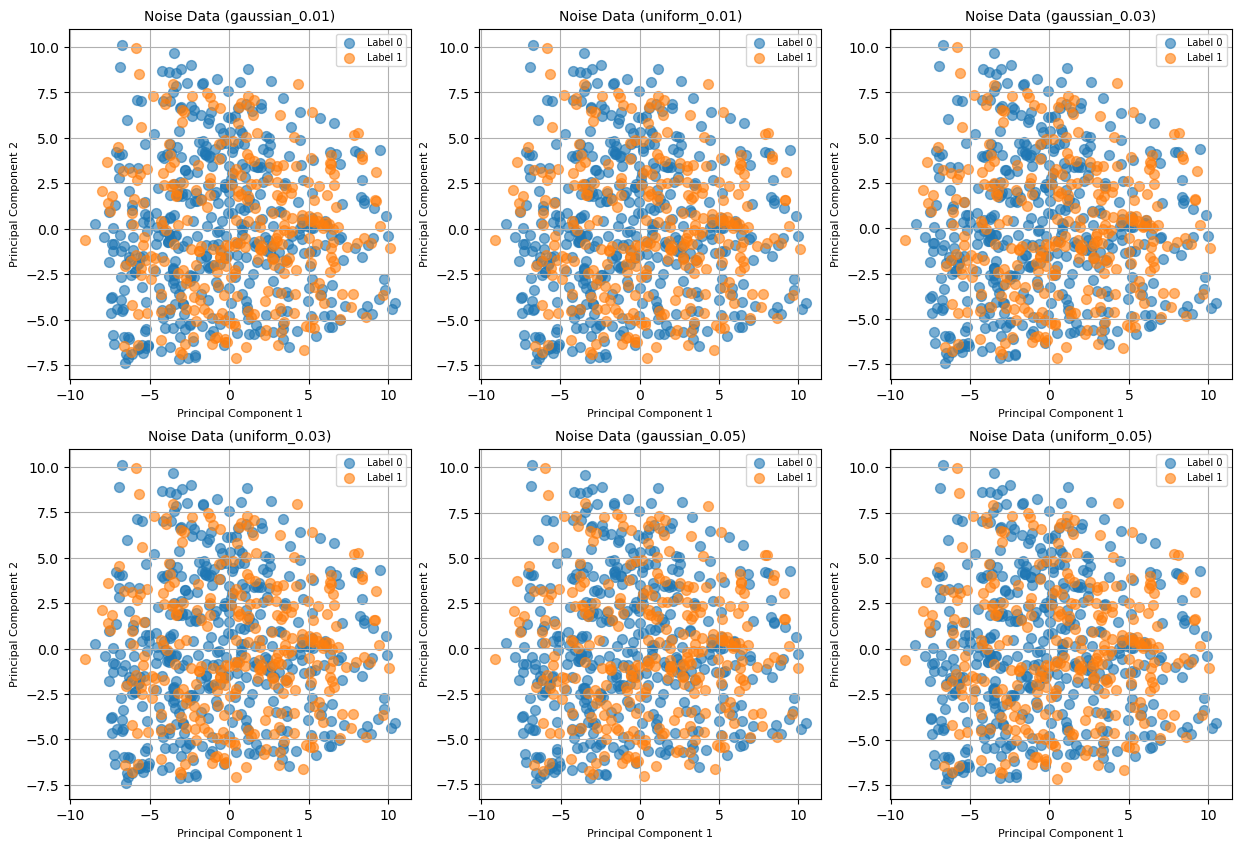

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

positions = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]
i = 0
for name, X_noise in noise_data.items():
    X_noise_pca = pca.transform(X_noise)
    plot_pca(X_noise_pca, y_train, f'Noise Data ({name})', axes[positions[i]])
    i += 1

#### 3.4.3 Sampling Techniques PCA

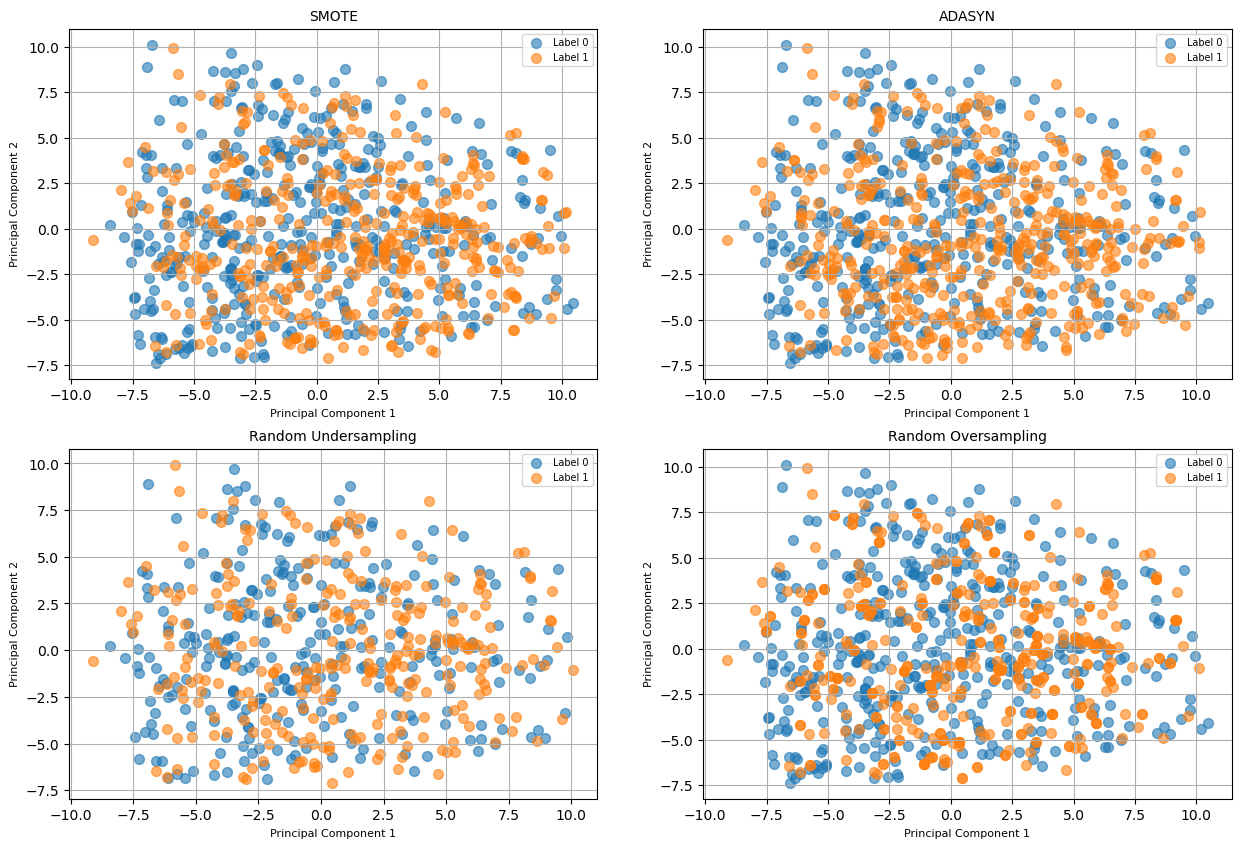

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

positions = [(0, 0), (0, 1), (1, 0), (1, 1)]

X_smote_pca = pca.transform(X_smote)
plot_pca(X_smote_pca, y_smote, 'SMOTE', axes[positions[0]])

X_adasyn_pca = pca.transform(X_adasyn)
plot_pca(X_adasyn_pca, y_adasyn, 'ADASYN', axes[positions[1]])

X_under_pca = pca.transform(X_under)
plot_pca(X_under_pca, y_under, 'Random Undersampling', axes[positions[2]])

X_over_pca = pca.transform(X_over)
plot_pca(X_over_pca, y_over, 'Random Oversampling', axes[positions[3]])

### 3.5 Technique Runs

#### 3.5.1 Sampling augmentation techniques and baseline runs

In [36]:
base_results, base_importances = train_runs(X_train, y_train, X_test, y_test, base_params, seeds)
smote_results, smote_importances = train_runs(X_smote, y_smote, X_test, y_test, base_params, seeds)
adasyn_results, adasyn_importances = train_runs(X_adasyn, y_adasyn, X_test, y_test, base_params, seeds)
under_results, under_importances = train_runs(X_under, y_under, X_test, y_test, base_params, seeds)
over_results, over_importances = train_runs(X_over, y_over, X_test, y_test, base_params, seeds)

#### 3.5.2 Mixup Runs

In [37]:
mixup_results = {}
mixup_importances = {}

for technique, _ in mixup_data.items():
    
    mixup_result, mixup_importance = train_runs(
        mixup_data[technique]['X'], 
        mixup_data[technique]['y'], 
        X_test, 
        y_test, 
        base_params, 
        seeds
    )
    
    mixup_results[technique] = mixup_result
    mixup_importances[technique] = mixup_importance

#### 3.5.3 Noise Injection Runs

In [38]:
gaussian_results = {}
gaussian_importances = {}

uniform_results = {}
uniform_importances = {}

for technique, X_noise in noise_data.items():
    
    result, importance = train_runs(
        X_noise, 
        y_train, 
        X_test, 
        y_test, 
        base_params, 
        seeds
    )
    
    if 'gaussian' in technique:
        gaussian_results[technique] = result
        gaussian_importances[technique] = importance

    if 'uniform' in technique:
        uniform_results[technique] = result
        uniform_importances[technique] = importance

## 4. Results 

### 4.1 Feature Stability 

In [39]:
importances = pd.DataFrame(data=base_importances, index=columns, columns=['baseline'])

#### 4.1.1 Mixup

In [40]:
mixup_importances_df = importances.copy(deep=True)

for ratio, importance in mixup_importances.items():
    mixup_importances_df[ratio] = importance

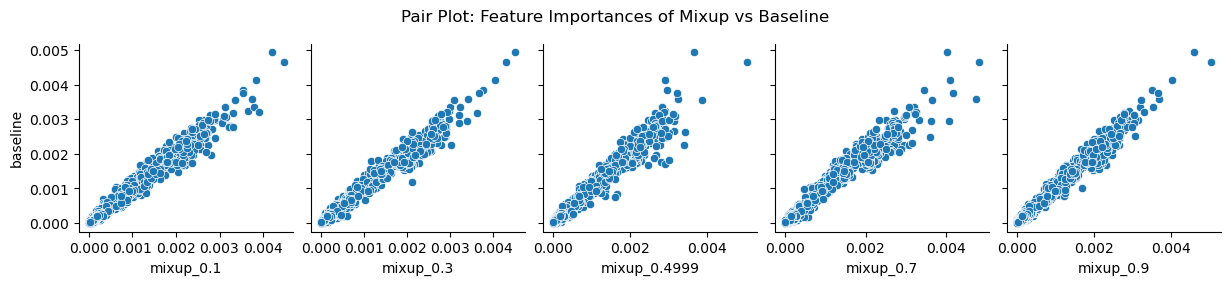

In [41]:
sns.pairplot(
    mixup_importances_df, 
    y_vars= ["baseline"], 
    x_vars = mixup_importances_df.columns.difference(["baseline"]), 
    kind = 'scatter'
)
plt.suptitle('Pair Plot: Feature Importances of Mixup vs Baseline', y=1.1)
plt.show()

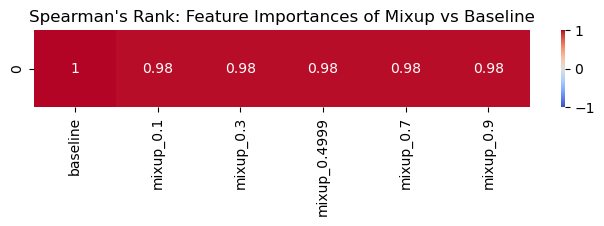

In [42]:
correlation_matrix = mixup_importances_df.corrwith(mixup_importances_df['baseline'],method='spearman')

plt.figure(figsize=(8, 1))
sns.heatmap(correlation_matrix.to_frame().T, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Spearman's Rank: Feature Importances of Mixup vs Baseline")
plt.show()

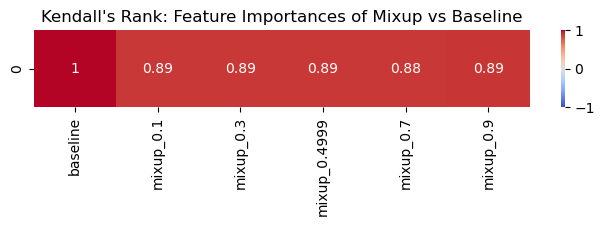

In [43]:
correlation_matrix = mixup_importances_df.corrwith(mixup_importances_df['baseline'],method='kendall')

plt.figure(figsize=(8, 1))
sns.heatmap(correlation_matrix.to_frame().T, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Kendall's Rank: Feature Importances of Mixup vs Baseline")
plt.show()

####  4.1.2 Noise Injection

##### Gaussian Noise

In [44]:
gaussian_importances_df = importances.copy(deep=True)

for noise_levels, importance in gaussian_importances.items():
    gaussian_importances_df[noise_levels] = importance

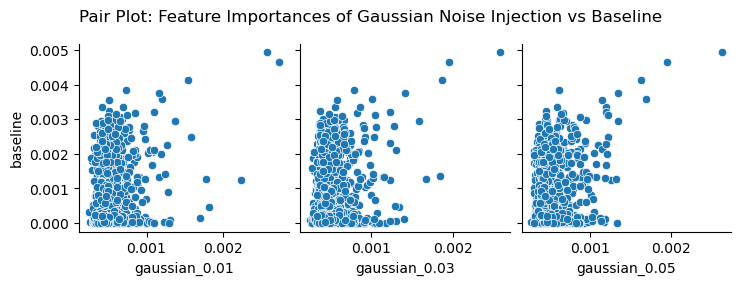

In [45]:
sns.pairplot(
    gaussian_importances_df, 
    y_vars= ["baseline"], 
    x_vars = gaussian_importances_df.columns.difference(["baseline"]), 
    kind = 'scatter'
)
plt.suptitle('Pair Plot: Feature Importances of Gaussian Noise Injection vs Baseline', y=1.1)
plt.show()

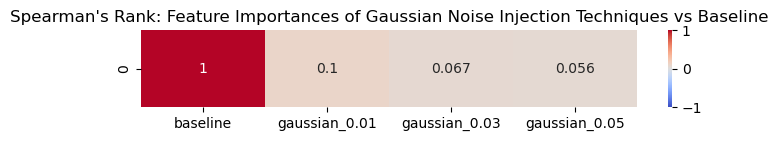

In [46]:
correlation_matrix = gaussian_importances_df.corrwith(gaussian_importances_df['baseline'],method='spearman')

plt.figure(figsize=(8, 1))
sns.heatmap(correlation_matrix.to_frame().T, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Spearman's Rank: Feature Importances of Gaussian Noise Injection Techniques vs Baseline")
plt.show()

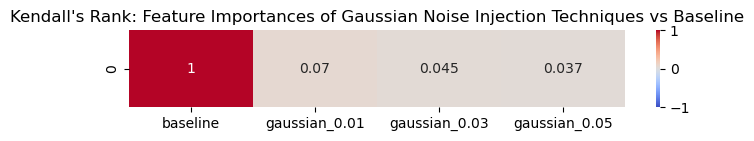

In [47]:
correlation_matrix = gaussian_importances_df.corrwith(gaussian_importances_df['baseline'],method='kendall')

plt.figure(figsize=(8, 1))
sns.heatmap(correlation_matrix.to_frame().T, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Kendall's Rank: Feature Importances of Gaussian Noise Injection Techniques vs Baseline")
plt.show()

##### Uniform Noise

In [48]:
uniform_importances_df = importances.copy(deep=True)

for noise_levels, importance in uniform_importances.items():
    uniform_importances_df[noise_levels] = importance

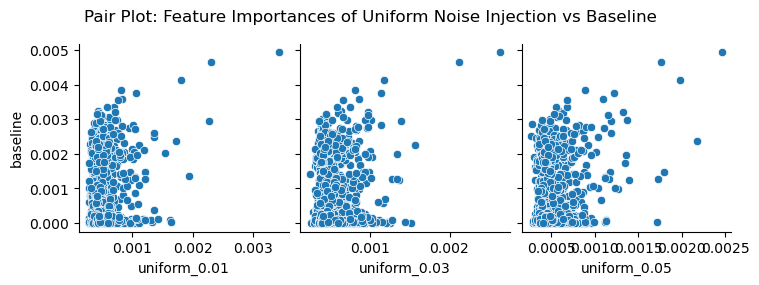

In [49]:
sns.pairplot(
    uniform_importances_df, 
    y_vars= ["baseline"], 
    x_vars = uniform_importances_df.columns.difference(["baseline"]), 
    kind = 'scatter'
)
plt.suptitle('Pair Plot: Feature Importances of Uniform Noise Injection vs Baseline', y=1.1)
plt.show()

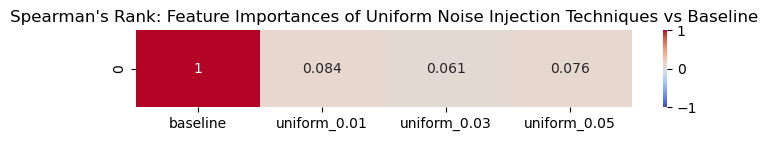

In [50]:
correlation_matrix = uniform_importances_df.corrwith(uniform_importances_df['baseline'],method='spearman')

plt.figure(figsize=(8, 1))
sns.heatmap(correlation_matrix.to_frame().T, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Spearman's Rank: Feature Importances of Uniform Noise Injection Techniques vs Baseline")
plt.show()

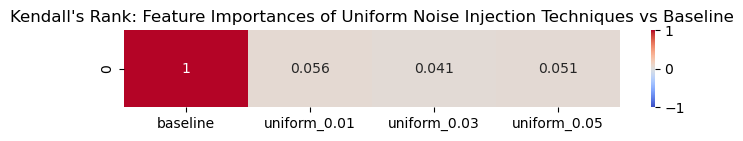

In [51]:
correlation_matrix = uniform_importances_df.corrwith(uniform_importances_df['baseline'],method='kendall')

plt.figure(figsize=(8, 1))
sns.heatmap(correlation_matrix.to_frame().T, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Kendall's Rank: Feature Importances of Uniform Noise Injection Techniques vs Baseline")
plt.show()

####  4.1.3 Sampling Techniques

In [52]:
importances_sampling = importances.copy(deep=True)
importances_sampling['SMOTE'] = smote_importances
importances_sampling['ADASYN'] = adasyn_importances
importances_sampling['RUS'] = under_importances
importances_sampling['ROS'] = over_importances

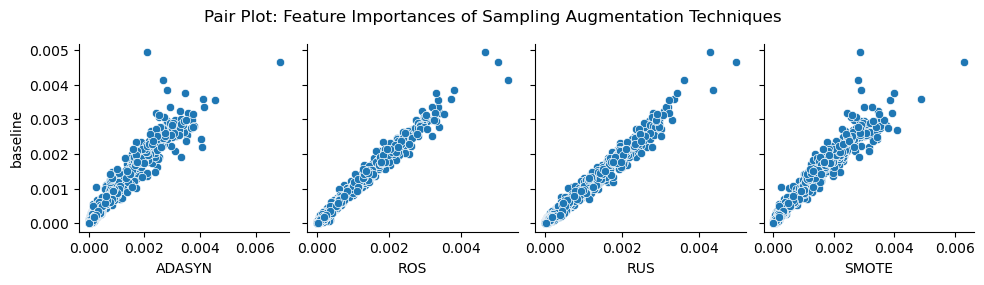

In [53]:
sns.pairplot(
    importances_sampling, 
    y_vars= ["baseline"], 
    x_vars = importances_sampling.columns.difference(["baseline"]), 
    kind = 'scatter'
)
plt.suptitle('Pair Plot: Feature Importances of Sampling Augmentation Techniques', y=1.1)
plt.show()

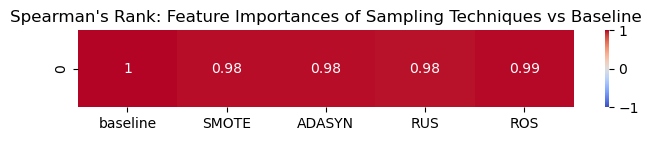

In [54]:
# Calculate the correlation matrix
correlation_matrix = importances_sampling.corrwith(importances_sampling['baseline'],method='spearman')

# Create a correlation heatmap
plt.figure(figsize=(8, 1))
sns.heatmap(correlation_matrix.to_frame().T, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Spearman's Rank: Feature Importances of Sampling Techniques vs Baseline")
plt.show()

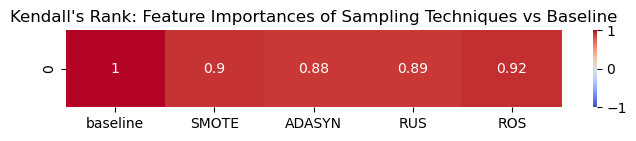

In [55]:
correlation_matrix = importances_sampling.corrwith(importances_sampling['baseline'],method='kendall')

plt.figure(figsize=(8, 1))
sns.heatmap(correlation_matrix.to_frame().T, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Kendall's Rank: Feature Importances of Sampling Techniques vs Baseline")
plt.show()

### 4.2 F1 Scores 

#### 4.2.1 *mixup* Technique F1 Scores 

In [56]:
category = []
values = []

for _, result in base_results.items():
    values.append(result['weighted avg']['f1-score'])
    category.append('base')
    
for technique, results in mixup_results.items():
        for _, result in results.items():
            values.append(result['weighted avg']['f1-score'])
            category.append(technique)

In [57]:
mixup_results_df = pd.DataFrame({
    'Category': category,
    'Values': values
})

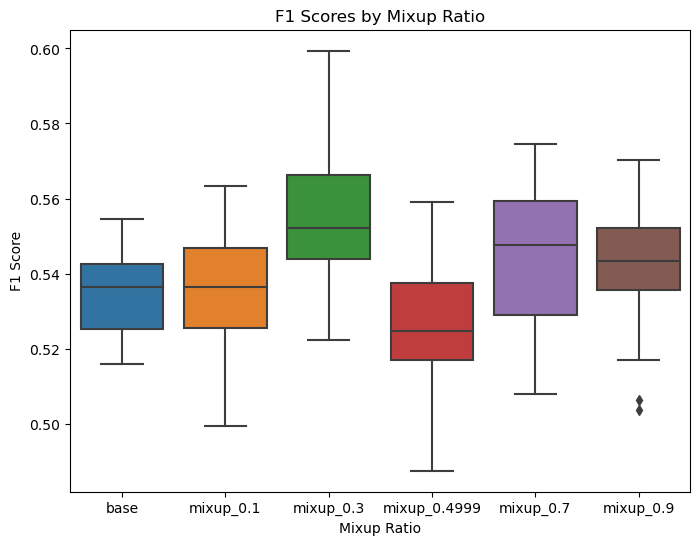

In [58]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Category', y='Values', data=mixup_results_df)

plt.title("F1 Scores by Mixup Ratio")
plt.ylabel("F1 Score")
plt.xlabel("Mixup Ratio")

plt.show()

#### 4.2.2 Noise Technique F1 Scores 

In [59]:
category = []
values = []

for _, result in base_results.items():
    values.append(result['weighted avg']['f1-score'])
    category.append('base')
    
for technique, results in gaussian_results.items():
        for _, result in results.items():
            values.append(result['weighted avg']['f1-score'])
            category.append(technique)
            
for technique, results in uniform_results.items():
        for _, result in results.items():
            values.append(result['weighted avg']['f1-score'])
            category.append(technique)

In [60]:
noise_results_df = pd.DataFrame({
    'Category': category,
    'Values': values
})

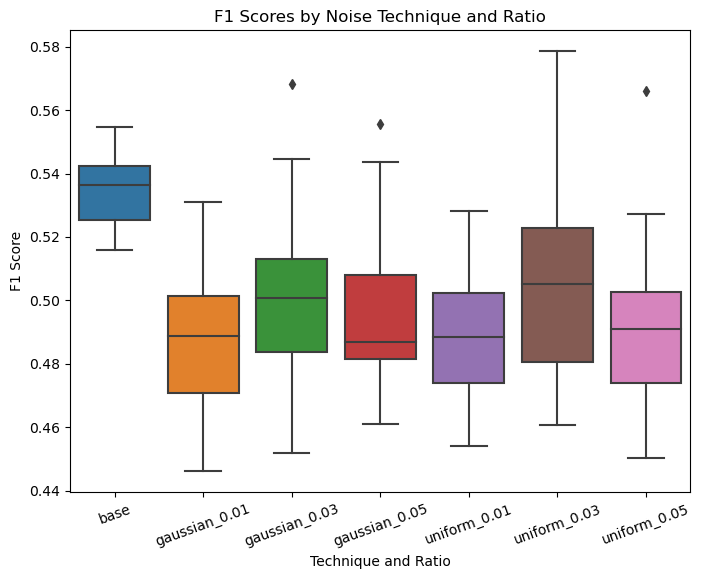

In [61]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Category', y='Values', data=noise_results_df)

plt.title("F1 Scores by Noise Technique and Ratio")
plt.ylabel("F1 Score")
plt.xlabel("Technique and Ratio")
plt.xticks(rotation = 20)

plt.show()

#### 4.2.2 All Technique Scores 

In [62]:
sampling_results = [
    ('Base',base_results),
    ('SMOTE',smote_results),
    ('ADASYN',adasyn_results),
    ('MIX_0.9',mixup_results['mixup_0.9']),
    ('RUS',under_results),
    ('ROS',over_results),
    ('UNI_0.03',uniform_results['uniform_0.03']),
    ('GAU_0.03',gaussian_results['gaussian_0.03']),
]

category = []
values = []

for results in sampling_results:
    for _, result in results[1].items():
        values.append(result['weighted avg']['f1-score'])
        category.append(results[0])

In [63]:
sampling_results_df = pd.DataFrame({
    'Category': category,
    'Values': values
})

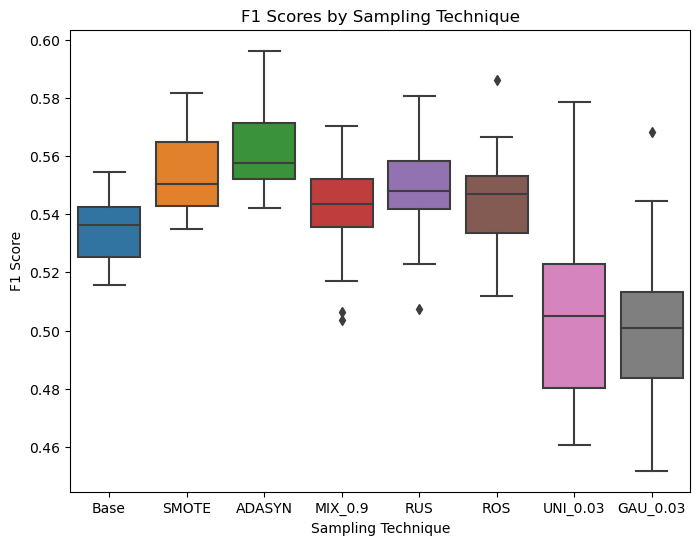

In [64]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Category', y='Values', data=sampling_results_df)

plt.title("F1 Scores by Sampling Technique")
plt.ylabel("F1 Score")
plt.xlabel("Sampling Technique")

plt.show()

### 4.3 ROC AUC Plots

In [65]:
def plot_average_roc_curve(results, ax):
    # Define a mean FPR space
    mean_fpr = np.linspace(0, 1, 100)
    all_tprs = []
    
    # Interpolate the TPRs of all seeds at the mean FPR
    for seed, values in results.items():
        interpolated_tpr = np.interp(mean_fpr, values['fpr'], values['tpr'])
        interpolated_tpr[0] = 0.0
        all_tprs.append(interpolated_tpr)
    
    # Compute the average TPR at each point on the mean FPR
    mean_tpr = np.mean(all_tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    # Calculate the AUC for the average ROC curve
    mean_auc = np.trapz(mean_tpr, mean_fpr)

    ax.plot(mean_fpr, mean_tpr, color='b', label=f'Average ROC (AUC: {mean_auc:.2f})')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Average ROC Curve')
    ax.legend(loc='lower right')

In [66]:
def subplot_roc_curves(results_list, titles):
    # Number of rows and columns for subplots
    n_rows = int(np.ceil(len(results_list) / 3))
    n_cols = 3

    # Create a grid of subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    
    # If there's only one row, axs is a 1D array
    if n_rows == 1:
        axs = np.expand_dims(axs, axis=0)
    
    # Loop through results and title_suffixes to plot each subplot
    for i, (res, title) in enumerate(zip(results_list, titles)):
        row = i // n_cols
        col = i % n_cols
        plot_average_roc_curve(res, axs[row, col])
        axs[row, col].set_title(f'Average ROC Curve For {title}')
    
    # Remove any unused subplots
    for j in range(i+1, n_rows*n_cols):
        row = j // n_cols
        col = j % n_cols
        axs[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

#### 4.3.1 ROC AUC for Sampling techniques and base model

In [67]:
sampling_results_list = [base_results, smote_results, adasyn_results, under_results, over_results]
sampling_plot_titles = ['Base', 'SMOTE', 'ADASYN', 'ROS', 'RUS']

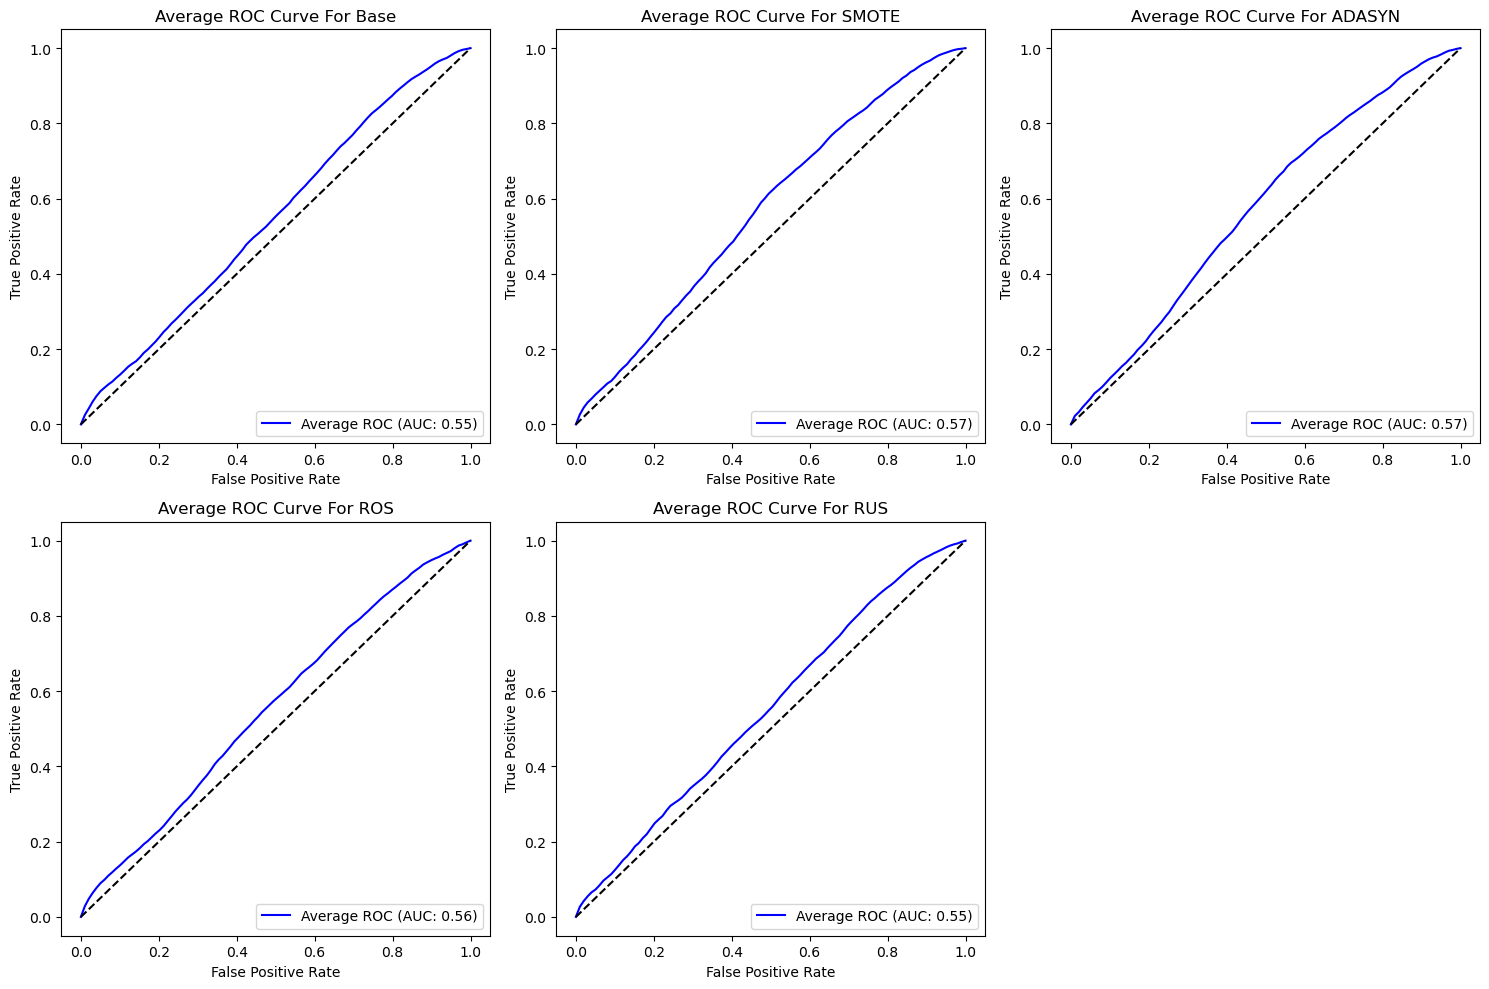

In [68]:
subplot_roc_curves(sampling_results_list, sampling_plot_titles)

#### 4.3.2 ROC AUC for Mixup

In [69]:
def extract_results_from_mixup(mixup_results):
    """
    Extract results and title suffixes from the mixup_results dictionary.
    """
    extracted_results = []
    titles = []

    # Loop through the mixup_results dictionary
    for mixup_key, results in mixup_results.items():
        # Extract the ROC curve data for each level of augmentation
        roc_data = {}
        for seed, metrics in results.items():
            roc_data[seed] = {
                'fpr': metrics['fpr'],
                'tpr': metrics['tpr']
            }
        
        # Append the extracted data and title suffix
        extracted_results.append(roc_data)
        title = mixup_key.split('_')[-1]  # Extract the augmentation level from the key
        titles.append(title)

    return extracted_results, titles

In [70]:
mixup_results_list, mixup_plot_titles = extract_results_from_mixup(mixup_results)
mixup_plot_titles = ['Mixup level of ' + item for item in mixup_plot_titles]

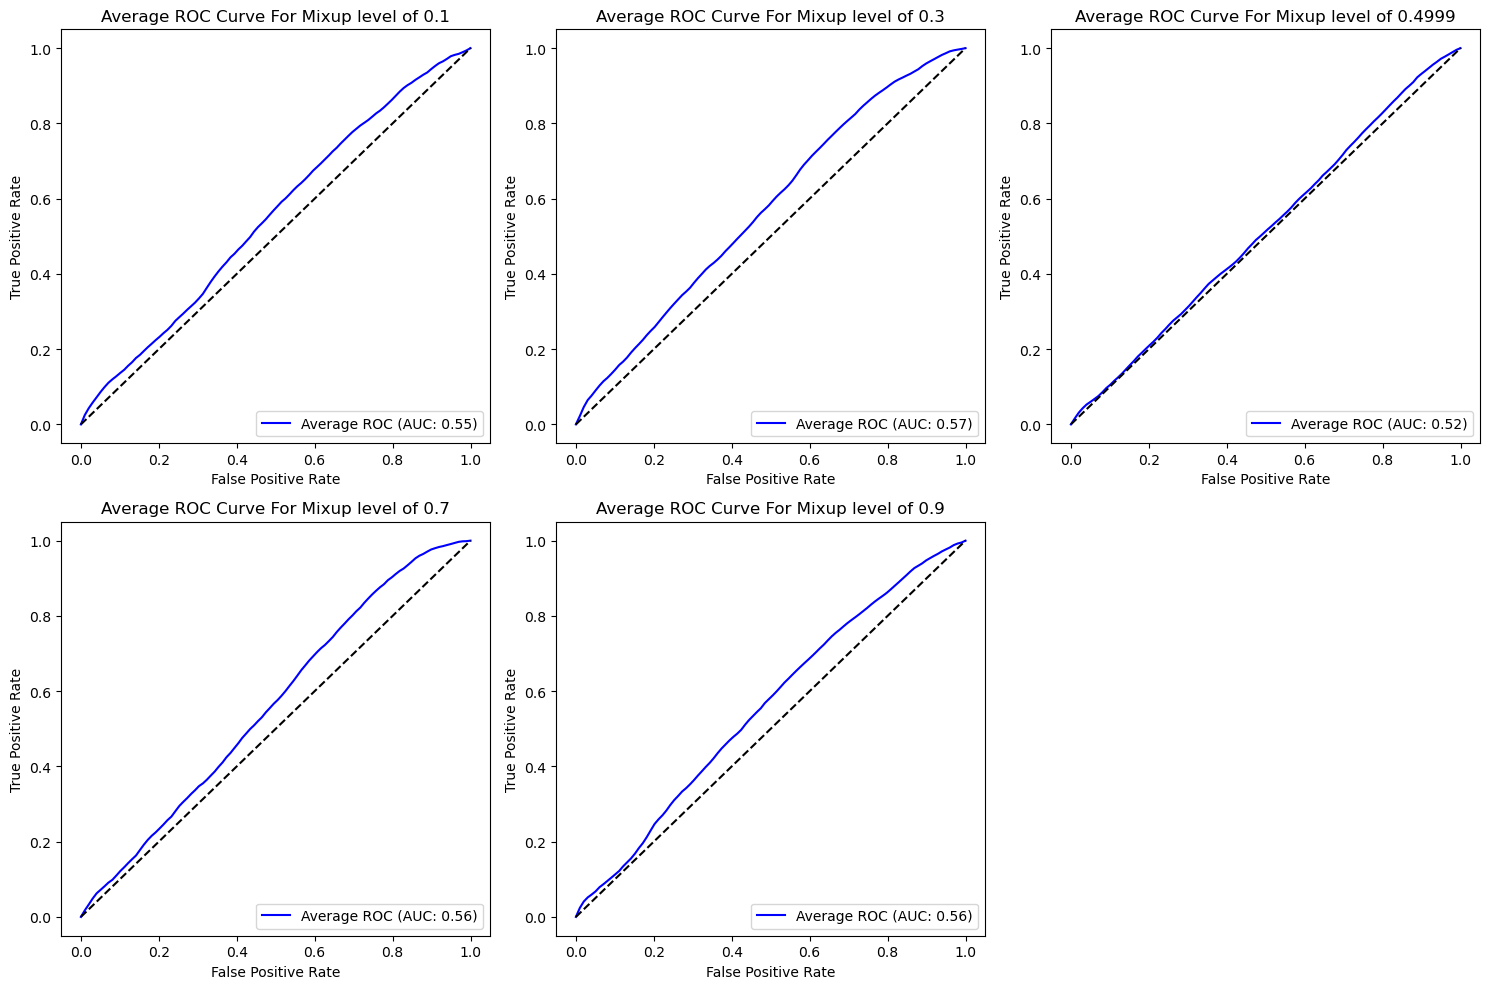

In [71]:
subplot_roc_curves(mixup_results_list, mixup_plot_titles)

#### 4.3.3 ROC AUC for Gaussian Noise

In [72]:
gaussian_results_list, gaussian_plot_titles = extract_results_from_mixup(gaussian_results)
gaussian_plot_titles = ['Gaussian Noise of ' + item for item in gaussian_plot_titles]

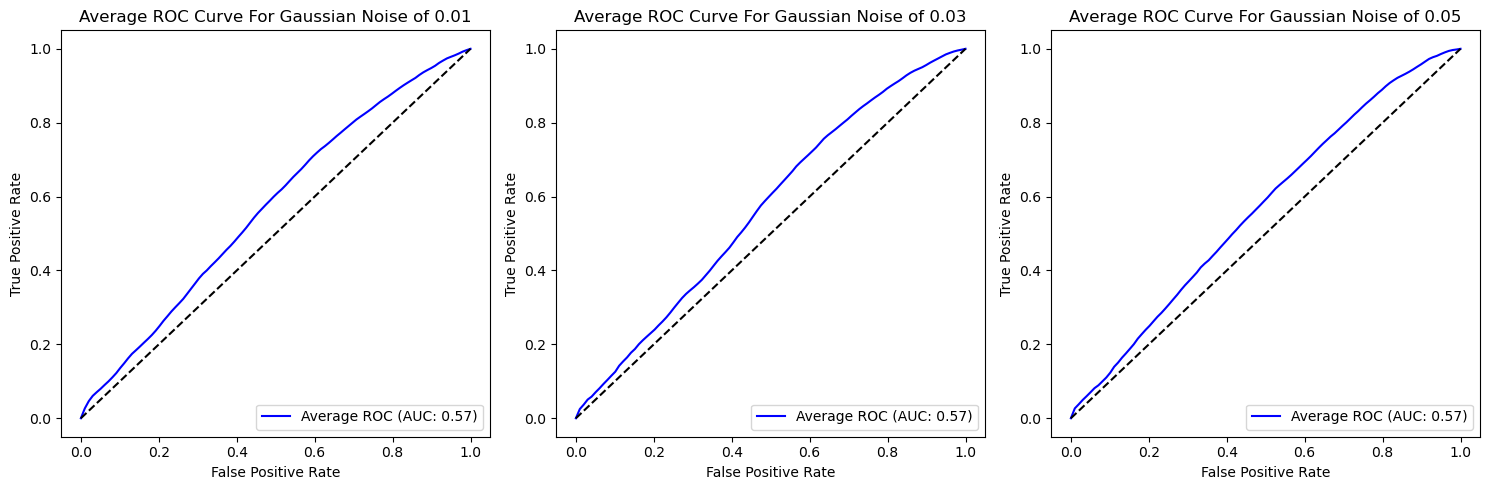

In [73]:
subplot_roc_curves(gaussian_results_list, gaussian_plot_titles)

#### 4.3.4 ROC AUC for Uniform Noise

In [74]:
uniform_results_list, uniform_plot_titles = extract_results_from_mixup(uniform_results)
uniform_plot_titles = ['Uniform Noise of ' + item for item in uniform_plot_titles]

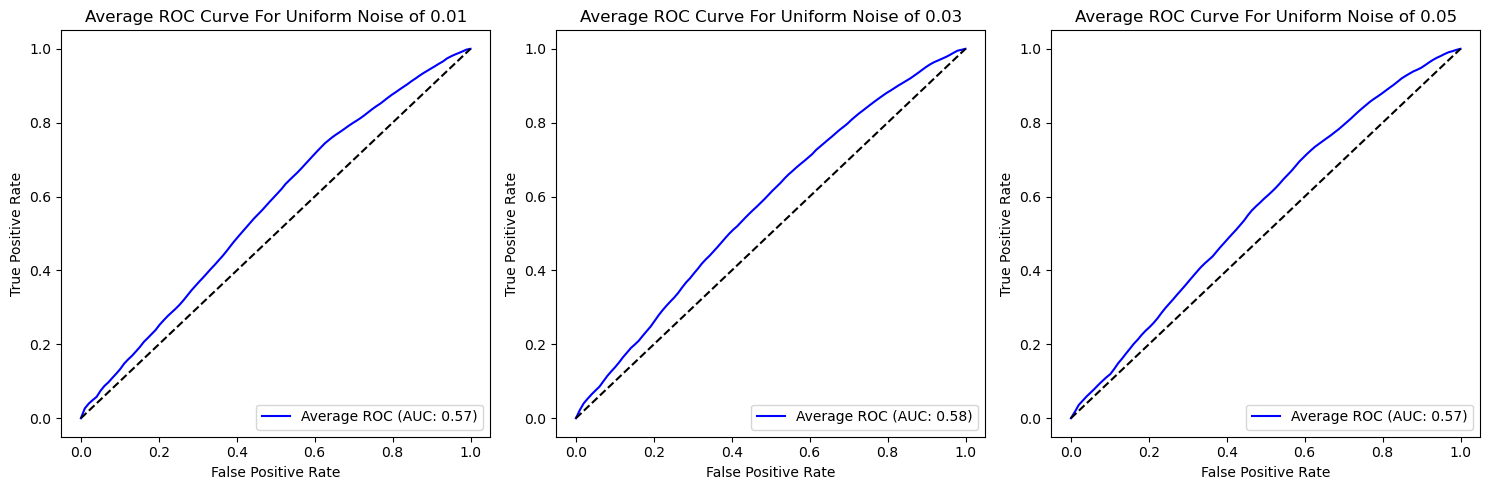

In [75]:
subplot_roc_curves(uniform_results_list, uniform_plot_titles)

### 4.4 Classification Report
Collecting all the evaluation metrics for each technique into a single table for direct comparison.

In [77]:
def get_score_averages(results_dic, seeds):
    '''Gets the average precision, recall and F1 scores for each technique'''
    precision = 0
    recall = 0
    f1_score = 0
    for seed in seeds:
        precision += results_dic[str(seed)]['weighted avg']['precision']
        recall += results_dic[str(seed)]['weighted avg']['recall']
        f1_score += results_dic[str(seed)]['weighted avg']['f1-score']
        
    precision = precision/len(seeds)
    recall = recall/len(seeds)
    f1_score = f1_score/len(seeds)
        
    averages = np.array([precision,recall,f1_score])
    return averages

In [78]:
# Get average scores for each technique
averages_dic = {}
averages_dic['baseline'] = get_score_averages(base_results, seeds)
averages_dic['SMOTE'] = get_score_averages(smote_results, seeds)
averages_dic['ADASYN'] = get_score_averages(adasyn_results, seeds)
averages_dic['Random Undersampling'] = get_score_averages(under_results, seeds)
averages_dic['Random Oversampling'] = get_score_averages(over_results, seeds)
for technique, results in mixup_results.items():
    averages_dic[technique] = get_score_averages(mixup_results[technique], seeds)
for technique, results in gaussian_results.items():
    averages_dic[technique] = get_score_averages(gaussian_results[technique], seeds)
for technique, results in uniform_results.items():
    averages_dic[technique] = get_score_averages(uniform_results[technique], seeds)

In [79]:
score_averages_df = pd.DataFrame.from_dict(averages_dic, orient='index', columns = ['precision','recall','f1-score'])

In [85]:
styled_df = score_averages_df.style \
    .background_gradient(subset=['precision'], cmap='Blues') \
    .background_gradient(subset=['recall'], cmap='Blues') \
    .background_gradient(subset=['f1-score'], cmap='Blues') \
    .set_properties(**{'font-size': '12pt', 'font-family': 'Calibri'})

display(styled_df)

,precision,recall,f1-score
baseline,0.538790,0.569892,0.534711
SMOTE,0.551768,0.562043,0.554828
ADASYN,0.561095,0.566129,0.563056
Random Undersampling,0.554027,0.545054,0.548101
Random Oversampling,0.543076,0.562473,0.545527
mixup_0.1,0.536482,0.563978,0.535879
mixup_0.3,0.555889,0.577634,0.555119
mixup_0.4999,0.525389,0.556129,0.525215
mixup_0.7,0.541007,0.552903,0.544271
mixup_0.9,0.546829,0.575054,0.542546
